In [1]:
# Import packages for calculation and plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, ScalarFormatter, AutoMinorLocator
# Pandas for convenient table export
import pandas as pd

## Brake station information

- Type: Type of brake system

    - TB: Tread Brake
    - DB: Disc Brake

- $p_C$: Brake cylinder pressure [Pa]
- $A_C$: Brake cylinder area [m$^2$]
- $i_C$: Cylinder transmission ratio [1]
- $\eta_C$: Cylinder efficiency [1]
- $F_{s,C}$: Return spring force [N]
- $i_{rig}$: Brake rigging transmission rate [1]
- $\eta_{rig,dyn}$: Brake rigging efficiency [1]
- $F_{s,rig}$: Brake rigging return spring force [N]
- $\mu_m$: Average brake pad or block friction coefficient [1]
- $r_S$: Effective friction radius [m]
- $D$: Wheel diameter [m]
- $t_a$: Delay time of cylinder pressure [s]
- $t_{ab}$: Rise time of cylinder pressure [s]
- $m_{st}$: Operating mass vehicle ready for service (per axle) [kg]
- $m_{rot}$: Rotating mass (per axle) [kg]
- $v_1$: Beginning of power parabola for ED brake [m/s]
- $v_2$: End of power parabola, beginning of constant force for ED brake [m/s]
- $v_3$: End of constant force for ED brake [m/s]
- $F_{max}$: Maximum ED brake force

### Example data

Example data is a simplified version of EN14531-1, Appendix C.

![Vehicle image](xMU2.png)

In [2]:
data = {'Type': ['1ED', '1ED', '1DB', '1DB', '1DB', '1DB', '1ED', '1ED'],
        'pC': [0, 0, 3.0, 3.0, 3.0, 3.0, 0, 0],
        'AC': [346, 346, 324, 324, 324, 324, 346, 346], 
        'iC': [1, 1, 1, 1, 1, 1, 1, 1], 
        'etaC': [.95, .95, .98, .98, .98, .98, .95, .95], 
        'Fs,C': [0, 0, -500, -500, -500, -500, 0, 0],
        'irig': [5, 5, 5, 5, 5, 5, 5, 5], 
        'etarig,dyn': [0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95], 
        'Fs,rig': [0, 0, 0, 0, 0, 0, 0, 0], 
        'mum': [0.28, 0.28, 0.35, 0.35, 0.35, 0.35, 0.28, 0.28], 
        'rS': [.5, .5, 0.27, 0.27, 0.27, 0.27, .5, .5], 
        'D': [0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89], 
        'ta': [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3], 
        'tab': [1, 1, 1, 1, 1, 1, 1, 1],
        'mst': [15000, 15000, 14500, 14500, 14500, 14500, 15000, 15000],
        'mrot': [1500, 1500, 700, 700, 700, 700, 1500, 1500],
        'v1': [200/3.6, 200/3.6, 0, 0, 0, 0, 200/3.6, 200/3.6],
        'v2': [15, 15, 0, 0, 0, 0, 15, 15],
        'v3': [0, 0, 0, 0, 0, 0, 0, 0],
        'Fmax': [25000, 25000, 0, 0, 0, 0, 25000, 25000]
       }
df = pd.DataFrame(data = data, columns = ['Type','pC', 'AC', 'iC', 'etaC', 'Fs,C',
                        'irig', 'etarig,dyn', 'Fs,rig', 'mum', 
                        'rS', 'D', 'ta', 'tab', 'mst', 'mrot',
                                         'v1', 'v2', 'v3', 'Fmax'])

### Calculation of Forces

#### Brake cylinder force

Brake cylinder force is identical for disc and tread brake.

$$
F_C = p_C A_C i_C \eta_C + F_{c,C}
$$

#### Block or pad force

Block or pad forces may also be covered similarly when taking into account that $F_{s, rig} = 0$ for disc brakes and potentially $F_n$ relates to more than one block.

$$
F_n = F_b = F_C i_{rig} \eta_{rig, dyn} + F_{s, rig}
$$

#### Average force per brake unit

This worksheet omits transmissions (with $i_{tra}$ and $\eta_{tra}$). For tread brakes, select $r_S = \frac{1}{2} D$.

$$
\bar{F}_B,C = F_b \mu_m \frac{2 r_s}{D}
$$

In [3]:
# Brake cylinder force
df['FC'] = df['pC']*1e5*df['AC']*1e-4*df['iC']*df['etaC']+df['Fs,C']
# Block or pad force
df['Fb'] = df['FC']*df['irig']*df['etarig,dyn']+df['Fs,rig']
# Average force per brake unit
df['FB,i'] = df['Fb']*df['mum']*df['rS']/df['D']*2

#### Equivalent brake build-up time

\begin{equation}
t_{e,i} = t_a + \frac{t_{ab}}{2}
\end{equation}

In [4]:
# Equivalent brake build-up time
df['te,i'] = df['ta'] + 0.5*df['tab']

## Stopping distance calculation

Following losely EN 14531, App. D. The present calculcation takes into account rotating masses and a resistance force.

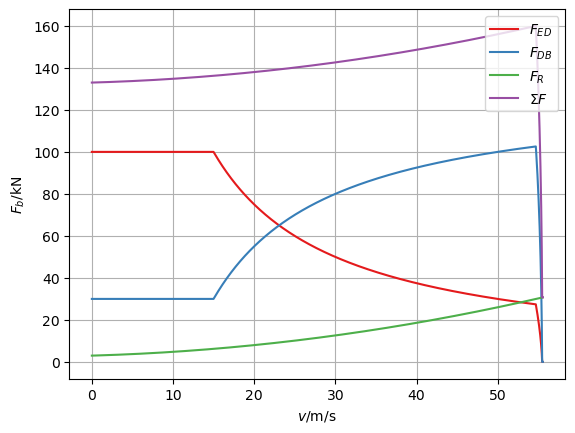

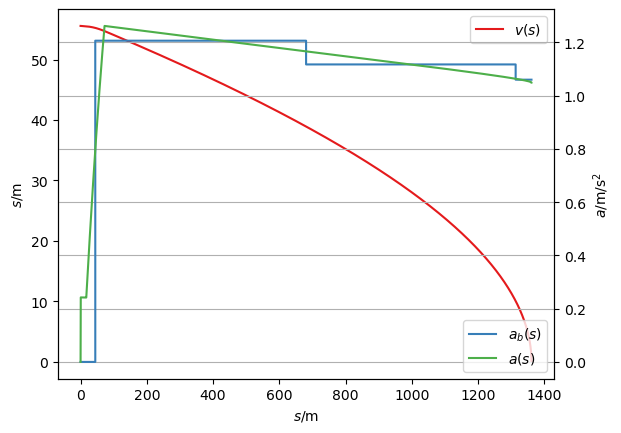

In [5]:
# Initial velocity
v0 = 200/3.6
# Terminal velocity
vfin = 0
# Vehicle data, resistance coefficients
A = 3000
B = 110
C = 7
# Dynamical mass
mdyn = df['mst'].sum() + df['mrot'].sum()
# Initialise velocity and time
vi = v0
ai = 0
si = 0
t = 0
# Time increment
dt = .01
# Create lists for storage of results
a = [0]
v = [v0]
s = [0]
F = [0]
FEDlist = [0]
FDBlist = [0]
FRalist = [A + B*v0 + C*v0**2]
tlist = [0]
# Required braking force
Freq = 130000
# Loop
while vi > vfin:
    ###################
    # Ride resistance
    FRa = A + B*vi + C*vi**2
    ###################
    # Braking force ED brake
    FED = 0
    for i in list(df[df['Type'] == '1ED'].index):
        # Read time constants
        ta = df.iloc[i]['ta']
        tab = df.iloc[i]['tab']
        # Read change-over velocity
        v2 = df.iloc[i]['v2']
        # Read maximum ED brake force
        Fmax = df.iloc[i]['Fmax']
        #########################
        # ED brake force at brake station i
        if t < ta:
            FEDi = 0
        elif t < (ta+tab):
            if vi > v2:
                # On parabola
                FEDi = Fmax*v2/vi*(t-ta)/tab
            else:
                FEDi = Fmax*(t-ta)/tab
        else:
            if vi > v2:
                # On parabola
                FEDi = Fmax*v2/vi
            else:
                FEDi = Fmax
        # Add force at brake station i
        FED = FED + FEDi
    ###################
    # Braking force disc brake
    FDB = 0
    for i in list(df[df['Type'] == '1DB'].index):
        # Read time constants
        ta = df.iloc[i]['ta']
        tab = df.iloc[i]['tab']
        #########################
        # DB brake force at brake station i
        Fmax = df.iloc[i]['Fb']
        # Required brake force from friction brake
        Ffric = Freq-FED
        if t < ta:
            FDBi = 0
        elif t < (ta+tab):
            FDBi = np.min([Ffric/4*(t-ta)/tab, Fmax*(t-ta)/tab])
        else:
            FDBi = np.min([Ffric/4, Fmax])
        FDB = FDB + FDBi
    t = t + dt
    tlist.append(t)
    Fi = FDB + FED + FRa
    F.append(Fi)
    FEDlist.append(FED)
    FDBlist.append(FDB)
    FRalist.append(FRa)
    vi = vi - ai*dt
    v.append(vi)
    si = si + vi*dt - 0.5*ai*dt**2
    s.append(si)
    ai = (Fi)/mdyn
    a.append(ai)
########################
# Deceleration curves
# Equivalent distance without braking
se = df['te,i'].loc[0]*v0
# Time steps without braking
ke = int(df['te,i'].loc[0]/dt)
# Calculate deceleration differences
adiff = a - np.max(a)
adiff = adiff[int(2*ke):]
# Limit value for new velocity range
da = 0.1
# Number of velocity ranges
nranges = np.floor((np.max(adiff) - np.min(adiff))/da)
# List for limit indices
ind = [ke]
# Find limits
for i in range(int(nranges)):
    ind.append(np.min(np.nonzero(np.abs(adiff)>(i+1)*da))+ke)
ind.append(-1)
# Lists for deceleration and related values
abi = [0, 0]
sbi = [0, se]
for i in range(len(ind[0:-1])):
    amean = np.abs(((v[ind[i]])**2 - (v[ind[i+1]])**2)/(2*(s[ind[i]] - s[ind[i+1]])))
    abi.append(amean)
    abi.append(amean)
    sbi.append(s[ind[i]])
    sbi.append(s[ind[i+1]])
#################
# Plot results
plt.figure()
plt.plot(v, 0.001*np.array(FEDlist), c = '#e41a1c')
plt.plot(v, 0.001*np.array(FDBlist), c = '#377eb8')
plt.plot(v, 0.001*np.array(FRalist), c = '#4daf4a')
plt.plot(v, 0.001*(np.array(FDBlist) + np.array(FEDlist) + np.array(FRalist)), c = '#984ea3')
plt.xlabel('$v$/m/s')
plt.ylabel('$F_b$/kN')
plt.legend(['$F_{ED}$', '$F_{DB}$', '$F_{R}$', '$\Sigma F$'])
plt.grid('both')
plt.savefig('FBlending.pdf')
##############################
# Plot braking curve
fig, ax1 = plt.subplots()
ax1.plot(s, v, c = '#e41a1c')
ax1.set_xlabel('$s$/m')
ax1.set_ylabel('$s$/m')
ax1.legend(['$v(s)$'])
ax2 = ax1.twinx()
ax2.plot(sbi, abi, c = '#377eb8')
ax2.plot(s, a, c = '#4daf4a')
ax2.set_ylabel('$a$/m/s$^2$')
ax2.legend(['$a_b(s)$', '$a(s)$'])
ax2.grid('both')
plt.savefig('BrakingCurvewDecelerations.pdf')

### Braked weight ratio

#### Replicate tests

Repeated brake distance measurements for $v_{max}$, 140 km/h, 120 km/h.



In [6]:
v0list = [100, 120, 140, 160]
bsdict = {}
for v0 in v0list:
    # Initial velocity
    v0str = str(v0)
    v0 = v0/3.6
    # Terminal velocity
    vfin = 0
    # Vehicle data, resistance coefficients
    A = 3000
    B = 110
    C = 7
    # Dynamical mass
    mdyn = df['mst'].sum() + df['mrot'].sum()
    # Initialise velocity and time
    vi = v0
    ai = 0
    si = 0
    t = 0
    # Time increment
    dt = .01
    # Create lists for storage of results
    a = [0]
    v = [v0]
    s = [0]
    F = [0]
    FEDlist = [0]
    FDBlist = [0]
    FRalist = [0]
    tlist = [0]
    # Required braking force
    Freq = 130000
    # Loop
    while vi > vfin:
        ###################
        # Ride resistance
        FRa = A + B*vi + C*vi**2
        ###################
        # Braking force ED brake
        FED = 0
        for i in list(df[df['Type'] == '1ED'].index):
            # Read time constants
            ta = df.iloc[i]['ta']
            tab = df.iloc[i]['tab']
            # Read change-over velocity
            v2 = df.iloc[i]['v2']
            # Read maximum ED brake force
            Fmax = df.iloc[i]['Fmax']
            #########################
            # ED brake force at brake station i
            if t < ta:
                FEDi = 0
            elif t < (ta+tab):
                if vi > v2:
                    # On parabola
                    FEDi = Fmax*v2/vi*(t-ta)/tab
                else:
                    FEDi = Fmax*(t-ta)/tab
            else:
                if vi > v2:
                    # On parabola
                    FEDi = Fmax*v2/vi
                else:
                    FEDi = Fmax
            # Add force at brake station i
            FED = FED + FEDi
        ###################
        # Braking force disc brake
        FDB = 0
        for i in list(df[df['Type'] == '1DB'].index):
            # Read time constants
            ta = df.iloc[i]['ta']
            tab = df.iloc[i]['tab']
            #########################
            # DB brake force at brake station i
            Fmax = df.iloc[i]['Fb']
            # Required brake force from friction brake
            Ffric = Freq-FED
            if t < ta:
                FDBi = 0
            elif t < (ta+tab):
                FDBi = np.min([Ffric/4*(t-ta)/tab, Fmax*(t-ta)/tab])
            else:
                FDBi = np.min([Ffric/4, Fmax])
            FDB = FDB + FDBi
        t = t + dt
        tlist.append(t)
        Fi = FDB + FED + FRa
        F.append(Fi)
        FEDlist.append(FED)
        FDBlist.append(FDB)
        FRalist.append(FRa)
        vi = vi - ai*dt
        v.append(vi)
        si = si + vi*dt - 0.5*ai*dt**2
        s.append(si)
        ai = (Fi)/mdyn
        a.append(ai)
    bsdict[v0str] = s[-1]

#### Plot braking distances

Into plot according to EN 16834.

(40.0, 240.0)

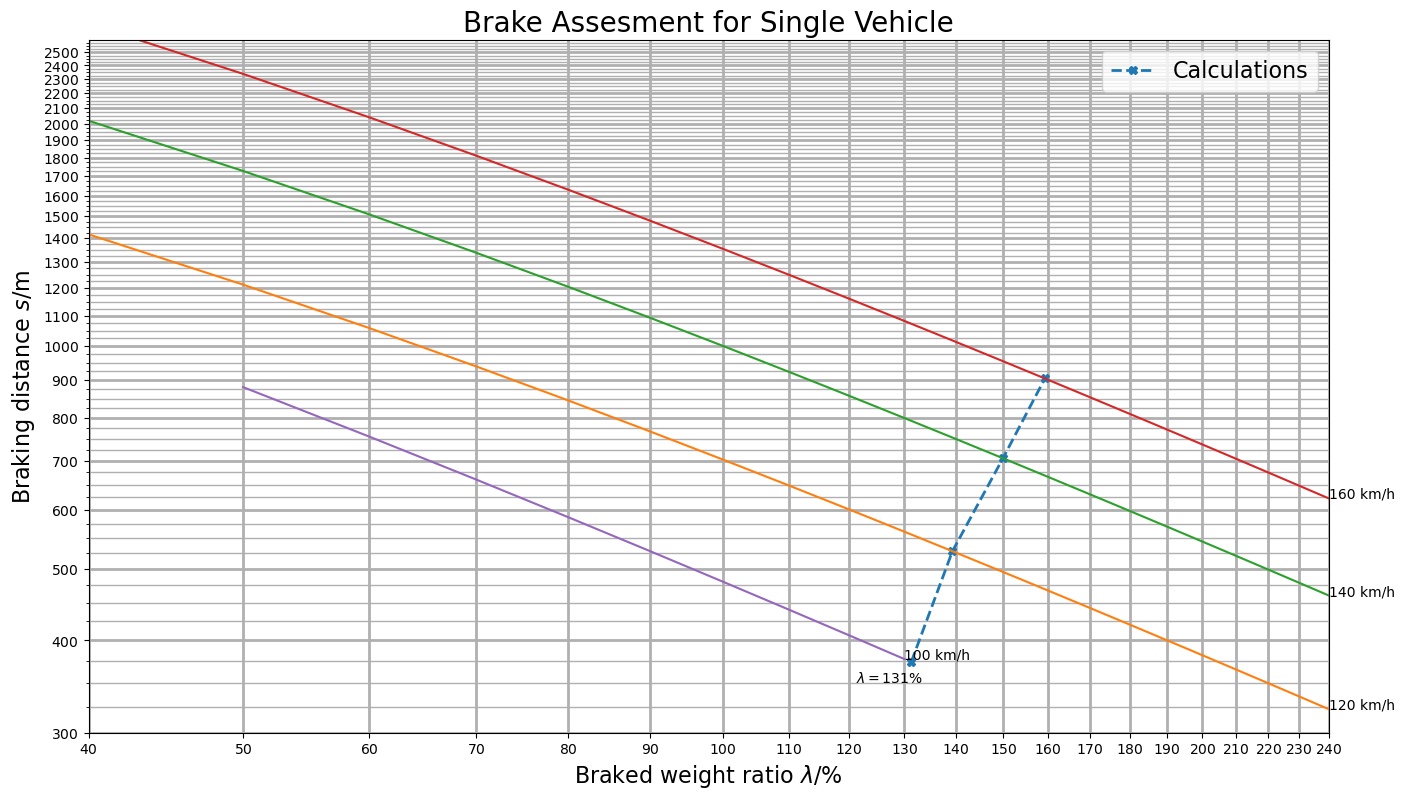

In [10]:
CDdict = {'100': [52840, 10],
'120': [83634, 19],
'140': [119179, 19],
'160': [161280, 19]}

# Single vehicles

curvedict = {}
for v in list(CDdict.keys())[1:]:
    l = np.arange(start = 40, stop = 250, step = 10)
    params = CDdict[str(v)]
    c = params[0]/(l+params[1])
    curvedict[str(v)] = c
for v in [100]:
    l = np.arange(start = 50, stop = 140, step = 10)
    params = CDdict[str(v)]
    c = params[0]/(l+params[1])
    curvedict[str(v)] = c
    
# Plotting
fig = plt.figure(figsize = (16, 9))
# Add measurements
bslambda = []
for v in list(CDdict.keys()):
    params = CDdict[str(v)]
    s = bsdict[str(v)]
    bslambda.append(params[0]/s-params[1])
plt.loglog(bslambda, list(bsdict.values()), 'X--', 
           linewidth = 2, label = "Calculations")
plt.annotate('$\lambda = $' + str(int(np.floor(np.min(bslambda)))) + '%', 
             (bslambda[0], list(bsdict.values())[0]),
            verticalalignment = 'top',
            xytext = (bslambda[0]-10, list(bsdict.values())[0]-10))
# Standard curves
for v in list(CDdict.keys())[1:]:
    c = curvedict[str(v)]
    l = np.arange(start = 40, stop = 250, step = 10)
    plt.loglog(l, c)
    plt.annotate(str(v) + ' km/h', (l[-1],c[-1]))
for v in [100]:
    c = curvedict[str(v)]
    l = np.arange(start = 50, stop = 140, step = 10)
    plt.loglog(l, c)
    plt.annotate(str(v) + ' km/h', (l[-1],c[-1]))
plt.legend(fontsize = 16)
# Limit axes
plt.ylim(300, 2600)
# Set ticks
plt.gca().set_yticks(ticks=np.arange(300, 2600, 100), minor = False)
plt.gca().set_yticklabels(labels=np.arange(300, 2600, 100), minor = False)
plt.gca().set_yticks(ticks=np.arange(300, 2600, 25), minor = True)
plt.gca().set_yticklabels(labels=[], minor = True)
plt.xticks(ticks=np.arange(30, 260, 10), labels=np.arange(300, 2600, 100))
# Set labels
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=True))
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=True))
# Activate grid
plt.grid(visible = True, which = 'major', linewidth = 2)
plt.grid(visible = True, which = 'minor', linewidth = 1)
# Axis labels
plt.xlabel('Braked weight ratio $\lambda/\%$', fontsize = 16)
plt.ylabel('Braking distance $s/\mathrm{m}$', fontsize = 16)
plt.title('Brake Assesment for Single Vehicle', fontsize = 20)
plt.xlim(40, 240)